# Tumour segmentation

In this project, the goal is to achieve the segmentation of a tumor from a MRI brain slice. As a segmentation algorithm can be very target dependant, in this project two approach will be considered.

**Threshold segmentation**

The first approach is rather specific to this case because of the parameters' choices that have been made and uses a threshold based segmentation.

As one can see by observing the histogram of this image, there are roughly 4 peaks: one around 0, another around 115, a third around 140 and a last around 220.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte

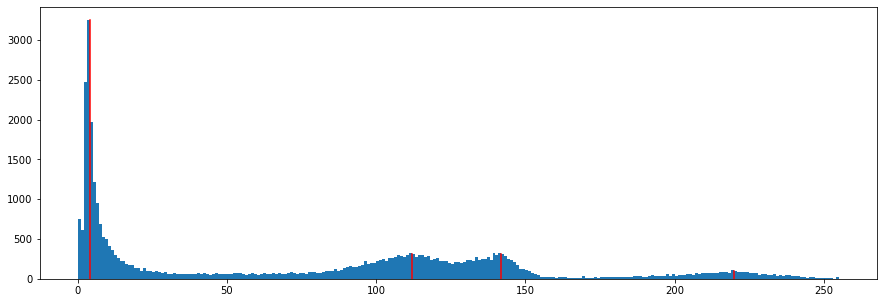

In [15]:
# To convert the 3 channels B&W image to 1 channel BW image
im = img_as_ubyte(imread('mri_brain.jpg', as_gray=True))

plt.figure(figsize=(15, 5))
h = plt.hist(im.flatten(), bins=range(256))
plt.plot([4,4],[0,h[0].max()], 'r-')
plt.plot([112,112],[0,313], 'r-')
plt.plot([142,142],[0,313], 'r-')
plt.plot([220,220],[0,100], 'r-')
plt.show()

- The "0-peak" can be associated to every black regions, 
- The "115-peak" and "140-peak" are associated to the dim gray regions,
- The "220-peak" is associated to the lighter parts of this image.

The grayscale levels of this tumor is fairly high and is associated to the "220-peak" in the histrogram. One can therefore easily imagine that the use of a good threshold might do the trick. This is what has been used in the next coding part:

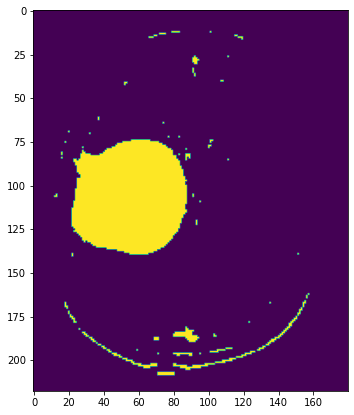

In [23]:
mask = im>155

plt.figure(figsize=(10, 7))
plt.imshow(mask)
plt.show()

A threshold of 155 is a fairly good threshold as the tumor seems relatively well disconnected form any unwanted undercut parts. We can then apply a labeling to this mask with a connectivity of 1 so only horizontal and vertical contacts are taken into account when labeling.

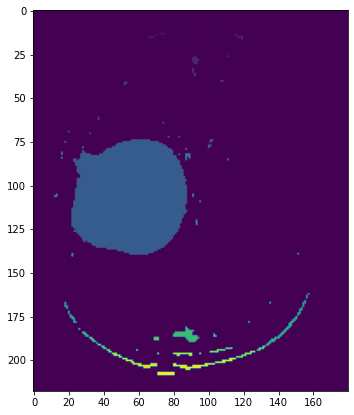

In [24]:
from skimage.measure import label, regionprops, find_contours

lab = label(mask, connectivity=1)

plt.figure(figsize=(10, 7))
plt.imshow(lab)
plt.show()

We can then use the region properties to select our tumor and to estimate its area.

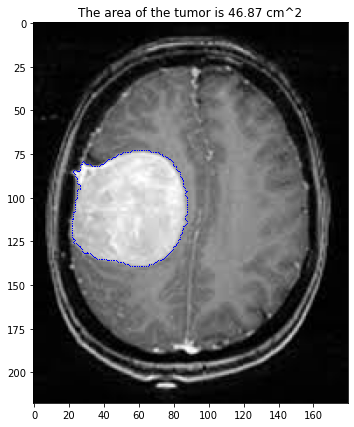

The area of the tumor is 46.87 cm^2


In [25]:
objects = regionprops(lab)

final_mask = im>255 # An array the size of im full of False

plt.figure(figsize=(10, 7))
plt.imshow(im, cmap=plt.cm.gray)

for obj in objects:
    if( obj.area < 100 ): continue
    for i in range(obj.coords.shape[0]):
        final_mask[obj.coords[i][0], obj.coords[i][1]] = True
    contour = find_contours(lab == obj.label, 0.5)[0]
    for j,c in enumerate(contour):
        plt.plot(c[1],c[0], 'b,')
    tumor_area = obj.area
plt.title('The area of the tumor is {:.2f} cm^2'.format(tumor_area*(0.115**2)))
plt.show()

print('The area of the tumor is {:.2f} cm^2'.format(tumor_area*(0.115**2)))

With the "final_mask" mask array we are able to only keep the tumor from the image. This is shown in the following cell:

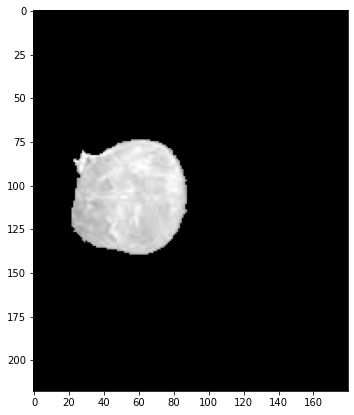

In [26]:
tumor_image = im*final_mask

plt.figure(figsize=(10, 7))
plt.imshow(tumor_image, cmap=plt.cm.gray)
plt.show()

**Watershed**

As the first approach based on threshold segmentation is a case-specific method, this part will focus another method which is more general and could be applied on different brain MRI images featuring a tumor with relatively the same distribution in gray level intensity.

This segmentation algorithm is known as the watershed transform, it is a more automatical method than the threshold approach but there are still parameters to set which may need a little adjustement when working on a different image.

For this method, we need to compute the gardient of the image to find the local minima which will be the perfect places to plant a marker. From those markers the watershed algorithm will segments the image, a labeling will then be used and with it region properties will be deduce.

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.morphology import watershed, disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops, find_contours
from skimage.feature import peak_local_max

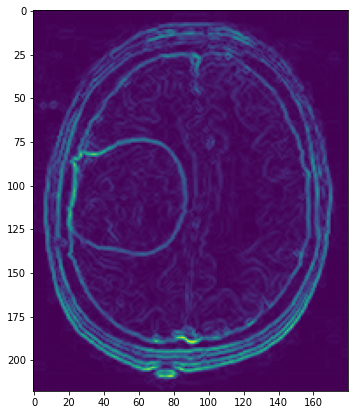

In [28]:
im = img_as_ubyte(imread('mri_brain.jpg', as_gray=True))

gradient = skr.gradient(skr.median(im), disk(1))

plt.figure(figsize=(10, 7))
plt.imshow(gradient)
plt.show()

As peak_local_max() allows us to determine the local maxima of the gradient, we only have to invert the gradient to compute the local minima.

As previously said, some settings may not be perfectly fitted for other MRI brain tumor images. Here it is the markers' parameters that might be a bit off for other images. Indeed, the min_distance parameter is highly image size dependant.

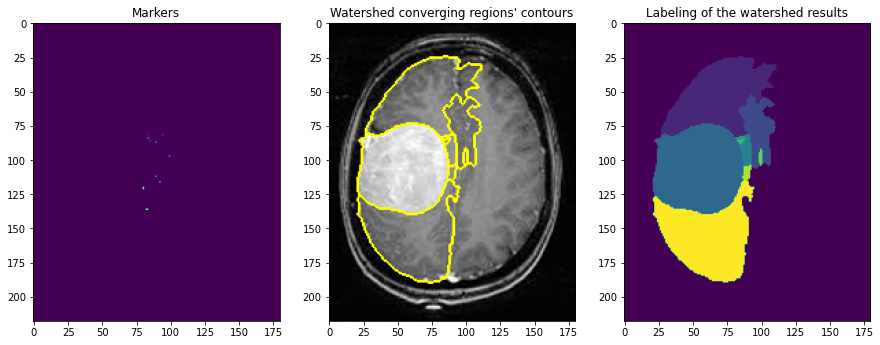

In [30]:
gradient_inv = gradient.max()-gradient
markers = label(peak_local_max(gradient_inv, indices=False, min_distance=80))

ws = watershed(gradient, markers)
lab = label(ws)

plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.imshow(markers)
plt.title("Markers")
plt.subplot(1,3,2)
plt.imshow(mark_boundaries(im,ws))
plt.title("Watershed converging regions' contours")
plt.subplot(1,3,3)
plt.imshow(lab)
plt.title("Labeling of the watershed results")
plt.show()

The region properties are then computed and used to differenciate the tumor region from the other labelled regions. The mean intensity is used to prune the unwanted regions, this could be done because of the higher intensity of the tumor region. An area filter for small areas which share with the tumor region a high intensity has been also implemented.

Here the values for the minimum region's mean intensity and for the miminum region's area are taken as low as possible for the mean intensity and relatively high for the area so it may not be too bad for other MRI images.

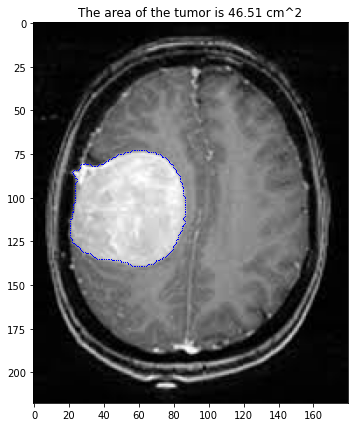

The area of the tumor is 46.51 cm^2


In [31]:
objects = regionprops(lab, intensity_image = im)

final_mask = im>255 # An array the size of im full of False

plt.figure(figsize=(10, 7))
plt.imshow(im, cmap=plt.cm.gray)

for obj in objects:
    if( obj.mean_intensity < 150 or obj.area < 100): continue
    for i in range(obj.coords.shape[0]):
        final_mask[obj.coords[i][0], obj.coords[i][1]] = True
    contour = find_contours(lab == obj.label, 0.5)[0]
    for j,c in enumerate(contour):
        plt.plot(c[1],c[0], 'b,')
    tumor_area = obj.area
plt.title('The area of the tumor is {:.2f} cm^2'.format(tumor_area*(0.115**2)))
plt.show()

print('The area of the tumor is {:.2f} cm^2'.format(tumor_area*(0.115**2)))

This gives a fairly similar result to the threshold based segmentation.

As previously done in the threshold segmentation part, a final_mask to only isolate the tumor has been implemented as well.

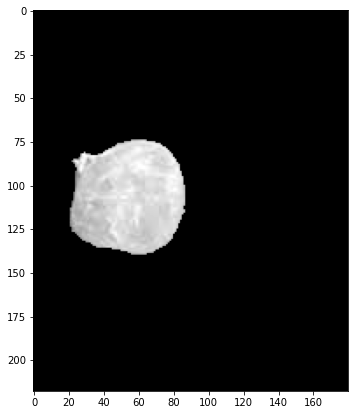

In [33]:
tumor_image = im*final_mask

plt.figure(figsize=(10, 7))
plt.imshow(tumor_image, cmap=plt.cm.gray)
plt.show()